In [1]:
import awkward0 as ak0
import awkward as ak
from configparser import ConfigParser
import itertools
import pyhf
pyhf.set_backend("jax")
from pyhf.exceptions import FailedMinimization
import uproot as up
import pandas as pd

from array import array
import ROOT
ROOT.gROOT.SetBatch(True)

from utils.xsecUtils import lumiMap
from utils.analysis.particle import Particle

from hep_ml import reweight

In [39]:
from utils.plotter import Hist

In [3]:
def histogram_intersection(h1, h2, bins):
    if h1[0] > h2[0]:
        h1_temp = h2
        h2 = h1
        h1 = h1_temp

    for i in range(len(bins)-1):
        if h1[i] > h2[i]:
            return bins[i]
    return
    

### Open signal file

In [4]:
MX = 700
MY = 400

In [5]:
presel_tree = up.open('/eos/uscms/store/user/srosenzw/sixb/ntuples/Summer2018UL/studies/NMSSM_XYH_YToHH_6b_MX_700_MY_400_2M/ntuple_test.root:sixBtree')
presel_cutflow = up.open('/eos/uscms/store/user/srosenzw/sixb/ntuples/Summer2018UL/studies/NMSSM_XYH_YToHH_6b_MX_700_MY_400_2M/ntuple_test.root:h_cutflow')

In [6]:
cutflow = up.open('/eos/uscms/store/user/srosenzw/sixb/ntuples/Summer2018UL/studies/NMSSM_XYH_YToHH_6b_MX_700_MY_400_2M/ntuple_test.root:h_cutflow')
cutflow = cutflow.to_numpy()[0]
total = cutflow[0]
xsec = 0.3 # pb
scale = lumiMap[2018][0] * xsec / total
print(cutflow*scale)

[17922.    12597.374 10202.637]


In [7]:
nbins = 60

In [8]:
njet_bins = np.arange(8)
id_bins = np.arange(-1, 7)
pt_bins = np.linspace(0, 500, 100)
btag_bins = np.linspace(0, 1.01, 100)
nH_bins = np.arange(5)
HID_bins = np.arange(-1, 4)
H_ticks = (HID_bins[:-1] + HID_bins[1:]) / 2

score_bins = np.linspace(0,1.01,102)

m_bins = np.linspace(500, 1300, nbins)
x_X_m = (m_bins[:-1] + m_bins[1:]) / 2

In [9]:
filename = '/uscms/home/srosenzw/nobackup/workarea/higgs/sixb_analysis/CMSSW_10_6_19_patch2/src/sixB/analysis/sixBanalysis/gnn/MX_700_MY_400_2M.root'
tree = up.open(filename + ':sixBtree')

In [12]:
sig_n_jet = tree['n_jet'].array()
sig_jet_pt = tree['jet_pt'].array()
sig_jet_eta = tree['jet_eta'].array()
sig_jet_phi = tree['jet_phi'].array()
sig_jet_m = tree['jet_m'].array()
sig_jet_btag = tree['jet_btag'].array()
sig_avg_btag = tree['jet_avg_btag'].array()
sig_asr_mask = tree['asr_mask'].array()
print(ak.sum(sig_asr_mask))
sig_acr_mask = tree['acr_mask'].array()
sig_vsr_mask = tree['vsr_mask'].array()
sig_vcr_mask = tree['vcr_mask'].array()

sig_X_m = tree['X_m'].array()

jet_sigID = tree['jet_signalId'].array()
higgs_id = (jet_sigID + 2) // 2 - 1

sig_gnn_score = ak.sort(tree['jet_gnn_score'].array(), ascending=False, axis=1)[:,:6]
sig_gnn_avg = ak.sum(sig_gnn_score, axis=1) / 6

updated_cutflow = np.append(cutflow, len(sig_n_jet))

41290


### Open data file

In [13]:
data_tree = up.open("/uscms/home/srosenzw/nobackup/workarea/higgs/sixb_analysis/CMSSW_10_6_19_patch2/src/sixB/analysis/sixBanalysis/gnn/data.root:sixBtree")
data_cutflow = up.open("/eos/uscms/store/user/srosenzw/sixb/ntuples/Summer2018UL/presel/JetHT_Data_UL/JetHT_Run2018_full/ntuple.root:h_cutflow")

In [15]:
data_avg_btag = data_tree['jet_avg_btag'].array()
data_btag = data_tree['jet_btag'].array()

data_gnn_score = ak.sort(data_tree['jet_gnn_score'].array(), ascending=False, axis=1)[:,:6]
data_gnn_avg = ak.sum(data_gnn_score, axis=1) / 6

data_asr_mask = data_tree['asr_mask'].array()
data_acr_mask = data_tree['acr_mask'].array()
data_vsr_mask = data_tree['vsr_mask'].array() 
data_vcr_mask = data_tree['vcr_mask'].array()

data_vr_mask = data_vsr_mask | data_vcr_mask

data_jet_pt = data_tree['jet_pt'].array()

### Calculate avg gnn and avg btag cut

signal loss: 8.0 %
data keep: 7.000000000000001 %
0.76


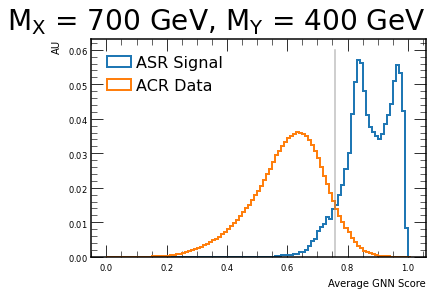

In [40]:
fig, ax = plt.subplots()

n_sig_gnn_avg = Hist(sig_gnn_avg[sig_asr_mask], bins=score_bins, ax=ax, label='ASR Signal')
n_data_gnn_avg = Hist(data_gnn_avg[data_acr_mask], bins=score_bins, ax=ax, label='ACR Data')

ax.set_xlabel('Average GNN Score')
ax.set_ylabel('AU')

ax.set_title(r"M$_X$ = 700 GeV, M$_Y$ = 400 GeV", fontsize=28)

ax.legend(loc=2)


gnn_cut = histogram_intersection(n_sig_gnn_avg, n_data_gnn_avg, score_bins)

ax.plot([gnn_cut, gnn_cut], [0,0.06], color='gray', alpha=0.5)

# gnn_cut = 0

sig_gnn_mask = sig_gnn_avg >= gnn_cut
data_gnn_mask = data_gnn_avg >= gnn_cut



print("signal loss:", round(ak.sum(sig_gnn_avg[sig_asr_mask & sig_asr_mask] < gnn_cut)/ak.sum(sig_asr_mask),2)*100, "%")
print("data keep:", round(ak.sum(data_gnn_avg[data_acr_mask & data_acr_mask] > gnn_cut)/ak.sum(data_acr_mask),2)*100, "%")


print(gnn_cut)

fig.savefig('plots/gnn/avg_gnn_score.pdf')

signal loss: 14 %
data keep: 16 %


0.56

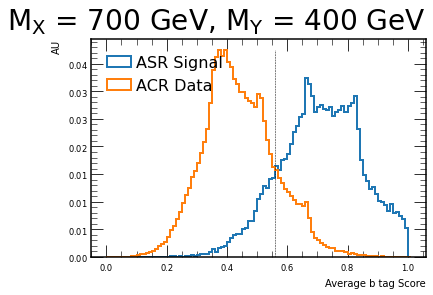

In [17]:
fig, ax = plt.subplots()

n_sig_btag = Hist(sig_avg_btag[sig_asr_mask & sig_gnn_mask], bins=score_bins, ax=ax, label='ASR Signal')
n_data_btag = Hist(data_avg_btag[data_acr_mask & data_gnn_mask], bins=score_bins, ax=ax, label='ACR Data')
# n_data_btag = Hist(data_avg_btag[data_acr_mask], bins=score_bins, ax=ax, density=False)

ax.set_xlabel('Average b tag Score')
ax.set_ylabel('AU')

ax.set_title(r"M$_X$ = 700 GeV, M$_Y$ = 400 GeV", fontsize=28)

ax.legend(loc=2)

ymax = max(n_sig_btag.max(), n_data_btag.max())

btag_cut = histogram_intersection(n_sig_btag, n_data_btag, score_bins)
ax.plot([btag_cut,btag_cut],[0,ymax],color='k',linestyle='--',linewidth=0.5)

sig_btag_mask = sig_avg_btag >= btag_cut
data_btag_mask = data_avg_btag >= btag_cut

print("signal loss:", round(ak.sum(sig_asr_mask & sig_gnn_mask & ~sig_btag_mask)/ak.sum(sig_asr_mask & sig_gnn_mask)*100), "%")
print("data keep:", round(ak.sum(data_acr_mask & data_gnn_mask & data_btag_mask)/ak.sum(data_acr_mask & data_gnn_mask)*100), "%")

# gnn_btag_cut

fig.savefig('plots/gnn/avg_btag_score.pdf')
btag_cut

### Apply avg gnn and avg btag cut

In [18]:
btag_gnn_sig_asr_mask = sig_asr_mask & sig_btag_mask & sig_gnn_mask
btag_gnn_sig_acr_mask = sig_acr_mask & sig_btag_mask & sig_gnn_mask

btag_gnn_asr_mask = data_asr_mask & data_gnn_mask
btag_gnn_acr_mask = data_acr_mask & data_gnn_mask
btag_gnn_vsr_mask = data_vsr_mask & data_gnn_mask
btag_gnn_vcr_mask = data_vcr_mask & data_gnn_mask

In [19]:
asr_mask = btag_gnn_asr_mask & ~data_btag_mask

acr_ls_mask = btag_gnn_acr_mask & ~data_btag_mask
acr_hs_mask = btag_gnn_acr_mask & data_btag_mask

vsr_ls_mask = btag_gnn_vsr_mask & ~data_btag_mask
vsr_hs_mask = btag_gnn_vsr_mask & data_btag_mask

vcr_ls_mask = btag_gnn_vcr_mask & ~data_btag_mask
vcr_hs_mask = btag_gnn_vcr_mask & data_btag_mask

In [20]:
asr_ls_X_m = data_tree['X_m'].array()[asr_mask] # low score by construction

acr_ls_X_m = data_tree['X_m'].array()[acr_ls_mask]
vsr_ls_X_m = data_tree['X_m'].array()[vsr_ls_mask]
vcr_ls_X_m = data_tree['X_m'].array()[vcr_ls_mask]
acr_hs_X_m = data_tree['X_m'].array()[acr_hs_mask]
vsr_hs_X_m = data_tree['X_m'].array()[vsr_hs_mask]
vcr_hs_X_m = data_tree['X_m'].array()[vcr_hs_mask]

### Generate signal ROOT histos

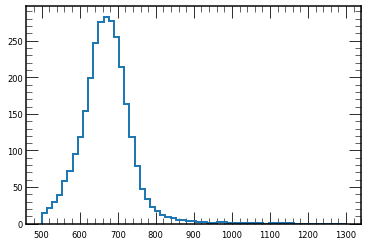

In [21]:
fig, ax = plt.subplots()

n_sr = Hist(sig_X_m[btag_gnn_sig_asr_mask], bins=m_bins, weights=scale, ax=ax, density=False)
# n_sr = Hist(X_m, bins=m_bins, weights=scale, ax=ax, density=False)

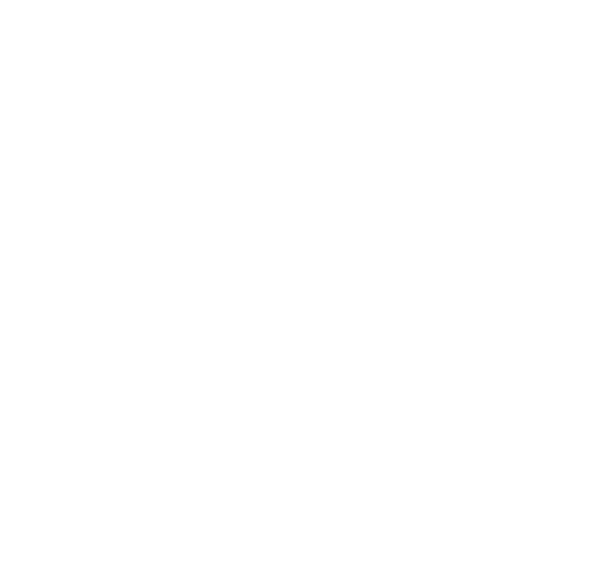

In [22]:
try: del canvas, ROOT_hist
except: pass

fout = ROOT.TFile(f"ml/gnn/MX_700_MY_400_2M.root","recreate")
fout.cd()

canvas = ROOT.TCanvas('c1','c1', 600, 600)
canvas.SetFrameLineWidth(3)
canvas.Draw()

h_title = f"signal"
ROOT_hist = ROOT.TH1D(h_title,";m_{X} [GeV];Events",nbins-1,array('d',list(m_bins)))
for i,(val) in enumerate(n_sr):
    ROOT_hist.SetBinContent(i+1, val) 

ROOT_hist.Draw("hist")
ROOT_hist.Write()
fout.Close()
# fout.Save()
# ROOT.gStyle.SetOptStat(0)

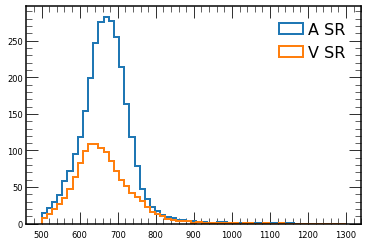

In [23]:
fig, ax = plt.subplots()

n_asr = Hist(sig_X_m[btag_gnn_sig_asr_mask], bins=m_bins, weights=scale, ax=ax, density=False, label='A SR')
n_vsr = Hist(sig_X_m[btag_gnn_sig_acr_mask], bins=m_bins, weights=scale, ax=ax, density=False, label='V SR')
# n_sr = Hist(X_m, bins=m_bins, weights=scale, ax=ax, density=False)

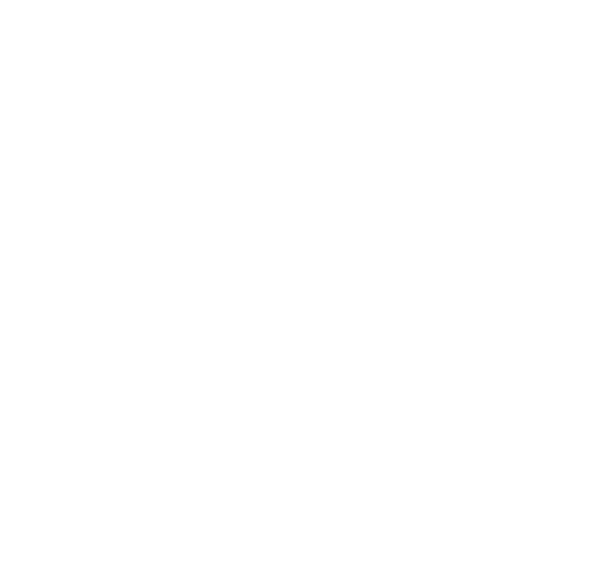

In [24]:
try: del canvas, ROOT_hist
except: pass

fout = ROOT.TFile(f"ml/gnn/signal_vsr.root","recreate")
fout.cd()

canvas = ROOT.TCanvas('c1','c1', 600, 600)
canvas.SetFrameLineWidth(3)
canvas.Draw()

h_title = f"signal"
ROOT_hist = ROOT.TH1D(h_title,";m_{X} [GeV];Events",nbins-1,array('d',list(m_bins)))
for i,(val) in enumerate(n_vsr):
    ROOT_hist.SetBinContent(i+1, val) 

ROOT_hist.Draw("hist")
ROOT_hist.Write()
fout.Close()
# fout.Save()
# ROOT.gStyle.SetOptStat(0)

## ACR BDT Training

In [25]:
cfg = 'config/bias_config.cfg'

config = ConfigParser()
config.optionxform = str
config.read(cfg)

Nestimators  = int(config['BDT']['Nestimators'])
learningRate = float(config['BDT']['learningRate'])
maxDepth     = int(config['BDT']['maxDepth'])
minLeaves    = int(config['BDT']['minLeaves'])
GBsubsample  = float(config['BDT']['GBsubsample'])
randomState  = int(config['BDT']['randomState'])
variables = config['BDT']['variables']
if isinstance(variables, str):
    variables = variables.split(", ")


In [26]:
asr_ls_features = {}
acr_ls_features = {}
acr_hs_features = {}
vcr_ls_features = {}
vcr_hs_features = {}
vsr_ls_features = {}
vsr_hs_features = {}

for var in variables:
    asr_ls_features[var] = abs(data_tree[var].array())[asr_mask]
    acr_ls_features[var] = abs(data_tree[var].array())[acr_ls_mask]
    acr_hs_features[var] = abs(data_tree[var].array())[acr_hs_mask]
    vcr_ls_features[var] = abs(data_tree[var].array()[vcr_ls_mask])
    vcr_hs_features[var] = abs(data_tree[var].array()[vcr_hs_mask])
    vsr_ls_features[var] = abs(data_tree[var].array())[vsr_ls_mask]
    vsr_hs_features[var] = abs(data_tree[var].array())[vsr_hs_mask]

asr_ls_df = pd.DataFrame(asr_ls_features)

acr_ls_df = pd.DataFrame(acr_ls_features)
acr_hs_df = pd.DataFrame(acr_hs_features)

vcr_ls_df = pd.DataFrame(vcr_ls_features)
vcr_hs_df = pd.DataFrame(vcr_hs_features)

vsr_ls_df = pd.DataFrame(vsr_ls_features)
vsr_hs_df = pd.DataFrame(vsr_hs_features)

In [27]:
acr_TF = sum(acr_hs_mask)/sum(acr_ls_mask)
vcr_TF = sum(vcr_hs_mask)/sum(vcr_ls_mask)

asr_initial_weights = np.ones(ak.sum(asr_mask))*acr_TF
acr_initial_weights = np.ones(ak.sum(acr_ls_mask))*acr_TF
vsr_initial_weights = np.ones(ak.sum(vsr_ls_mask))*vcr_TF

acr_ls_weights = np.ones(ak.sum(acr_ls_mask))*acr_TF
acr_hs_weights = np.ones(ak.sum([acr_hs_mask]))
vcr_ls_weights = np.ones(ak.sum(vcr_ls_mask))*vcr_TF
vcr_hs_weights = np.ones(ak.sum(vcr_hs_mask))

In [28]:
acr_reweighter_base = reweight.GBReweighter(
    n_estimators=Nestimators, 
    learning_rate=learningRate, 
    max_depth=maxDepth, 
    min_samples_leaf=minLeaves,
    gb_args={'subsample': GBsubsample})

acr_reweighter = reweight.FoldingReweighter(acr_reweighter_base, random_state=randomState, n_folds=2, verbose=False)
acr_reweighter.fit(acr_ls_df,acr_hs_df,acr_ls_weights,acr_hs_weights)

asr_weights_pred = acr_reweighter.predict_weights(asr_ls_df,asr_initial_weights,lambda x: np.mean(x, axis=0))
acr_weights_pred = acr_reweighter.predict_weights(acr_ls_df,acr_initial_weights,lambda x: np.mean(x, axis=0))

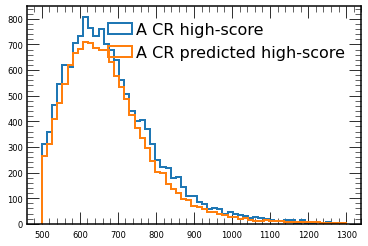

In [29]:
fig, ax = plt.subplots()

n_acr_hs = Hist(acr_hs_X_m, bins=m_bins, ax=ax, density=False, label='A CR high-score') # this is low-scoring sr
n_acr_hs_pred = Hist(acr_ls_X_m, bins=m_bins, weights=acr_weights_pred, ax=ax, label='A CR predicted high-score')

acr_TF_bvb = n_acr_hs / n_acr_hs_pred

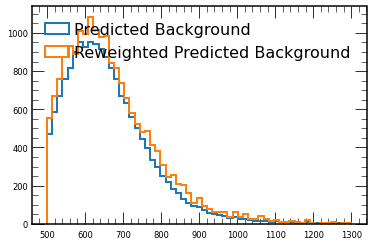

In [30]:
fig, ax = plt.subplots()

n_asr_pred = Hist(asr_ls_X_m, bins=m_bins, weights=asr_weights_pred, ax=ax, label='Predicted Background')
n_asr_pred_reweighted = Hist(x_X_m, bins=m_bins, weights=n_asr_pred*acr_TF_bvb, ax=ax, label='Reweighted Predicted Background')

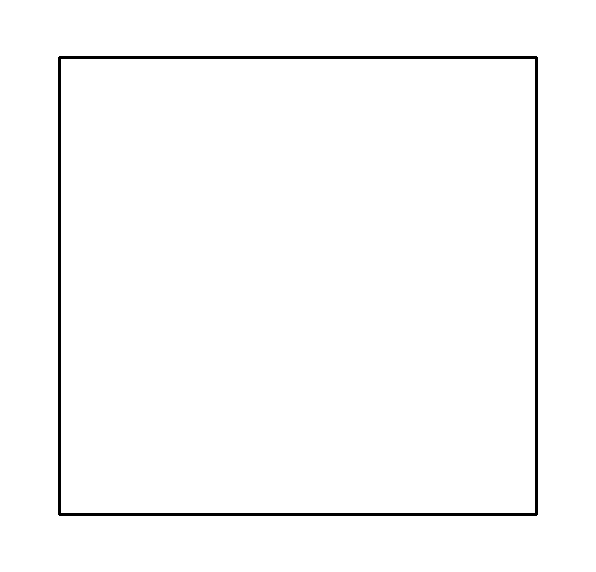

In [31]:
try: del canvas, ROOT_hist
except: pass

canvas = ROOT.TCanvas('c1','c1', 600, 600)
canvas.SetFrameLineWidth(3)
canvas.Draw()

fout = ROOT.TFile(f"ml/gnn/data.root","recreate")
fout.cd()

h_title = f"data"
ROOT_hist = ROOT.TH1D(h_title,";m_{X} [GeV];Events",nbins-1,array('d',list(np.linspace(375,1150,nbins))))
for i,(val) in enumerate(n_asr):
    ROOT_hist.SetBinContent(i+1, val)

ROOT_hist.Draw("hist")
ROOT_hist.Write()
ROOT.gStyle.SetOptStat(0)
fout.Close()

In [32]:
vcr_reweighter_base = reweight.GBReweighter(
    n_estimators=Nestimators, 
    learning_rate=learningRate, 
    max_depth=maxDepth, 
    min_samples_leaf=minLeaves,
    gb_args={'subsample': GBsubsample})

vcr_reweighter = reweight.FoldingReweighter(vcr_reweighter_base, random_state=randomState, n_folds=2, verbose=False)
vcr_reweighter.fit(vcr_ls_df,vcr_hs_df,vcr_ls_weights,vcr_hs_weights)

FoldingReweighter(base_reweighter=GBReweighter(gb_args={'subsample': 0.6},
                                               learning_rate=0.16, max_depth=5,
                                               n_estimators=100),
                  random_state=2020, verbose=False)

In [33]:
vsr_weights_pred = vcr_reweighter.predict_weights(vsr_ls_df,vsr_initial_weights,lambda x: np.mean(x, axis=0))
vcr_weights_pred = vcr_reweighter.predict_weights(vcr_ls_df,np.ones(ak.sum(vcr_ls_mask))*vcr_TF,lambda x: np.mean(x, axis=0))

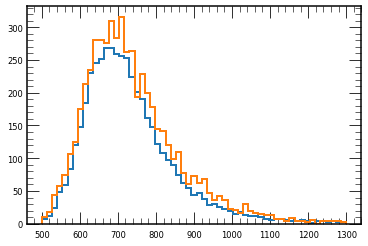

In [37]:
fig, ax = plt.subplots()

# n_srls = Hist(vsr_ls_X_m, bins=m_bins, ax=ax, density=False)
n_vcrhs_pred = Hist(vcr_ls_X_m, bins=m_bins, weights=vcr_weights_pred, ax=ax, density=False)
n_vcrhs = Hist(vcr_hs_X_m, bins=m_bins, ax=ax, density=False)
# n_vcrls = Hist(vcr_ls_X_m, bins=m_bins, ax=ax, density=False)

vcr_TF_bvb = np.nan_to_num(n_vcrhs / n_vcrhs_pred, 0)

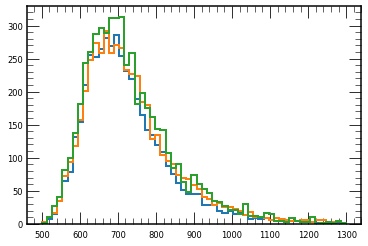

In [38]:
fig, ax = plt.subplots()

# n_srls = Hist(vsr_ls_X_m, bins=m_bins, ax=ax, density=False)
n_vsrhs_pred = Hist(vsr_ls_X_m, bins=m_bins, weights=vsr_weights_pred, ax=ax, density=False)
n_vsrhs = Hist(vsr_hs_X_m, bins=m_bins, ax=ax, density=False)

# n_vsrls = Hist(vsr_ls_X_m, bins=m_bins, ax=ax, density=False)
n_vsrhs_pred_weighted = Hist(x_X_m, bins=m_bins, weights=n_vsrhs_pred*vcr_TF_bvb, ax=ax)

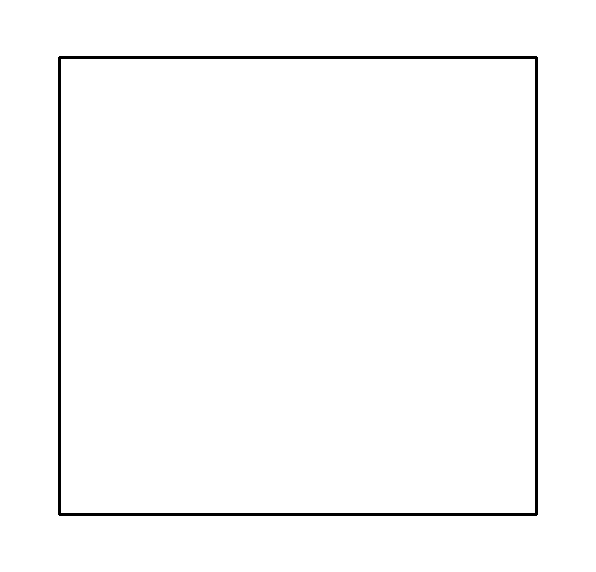

In [ ]:
try: del canvas, ROOT_hist
except: pass

canvas = ROOT.TCanvas('c1','c1', 600, 600)
canvas.SetFrameLineWidth(3)
canvas.Draw()

fout = ROOT.TFile(f"ml/gnn/data_vr.root","recreate")
fout.cd()

h_title_exp = f"data_exp"
h_title_obs = f"data_obs"

ROOT_hist = ROOT.TH1D(h_title_exp,";m_{X} [GeV];Events",nbins-1,array('d',list(np.linspace(375,1150,nbins))))
ROOT_hist_obs = ROOT.TH1D(h_title_obs,";m_{X} [GeV];Events",nbins-1,array('d',list(np.linspace(375,1150,nbins))))

for i,(val,val_vr) in enumerate(zip(n_vsrhs_pred, n_vsrhs)):
    ROOT_hist.SetBinContent(i+1, val)
    ROOT_hist_obs.SetBinContent(i+1, val_vr)

ROOT_hist.Draw("hist")
ROOT_hist_obs.Draw("hist")
ROOT_hist.Write()
ROOT_hist_obs.Write()
ROOT.gStyle.SetOptStat(0)
fout.Close()

### Limits

#### Analysis Signal Region

In [ ]:
bkg_est_asr = up.open('ml/gnn/data.root')
signal_asr = up.open('ml/gnn/MX_700_MY_400_2M.root')

h_data = bkg_est_asr['data']
h_signal = signal_asr['signal']

In [ ]:
norm = 2*np.sqrt(np.sum(h_data.errors()**2))/h_signal.counts().sum()
w = pyhf.simplemodels.uncorrelated_background(
    signal=(norm*h_signal.counts()).tolist(), bkg=h_data.counts().tolist(), bkg_uncertainty=h_data.errors().tolist()
)
data = h_data.counts().tolist()+w.config.auxdata

In [ ]:
# 80 bins

obs_limit_vsr, exp_limit_vsr, (scan, results) = pyhf.infer.intervals.upperlimit(
          data_vsr, w_vsr, poi, level=level, return_results=True
      )
obs_limit_vsr, exp_limit_vsr = norm_vsr*obs_limit_vsr, [ norm_vsr*lim for lim in exp_limit_vsr ]
np.array(exp_limit_vsr)*300, np.array(obs_limit_vsr)*300 # fb

(array([2.68824494, 3.35695767, 4.89118207, 5.97775454, 8.03435917]),
 6.725992760466909)

#### Validation Signal Region

In [ ]:
# bkg_est_vsr = up.open('ml/gnn/data_vsr.root')
bkg_vsr = up.open('ml/gnn/data_vr.root')
signal_vsr = up.open('ml/gnn/signal_vsr.root')

h_signal_vsr = signal_vsr['signal']
h_data_vsr_exp = bkg_vsr['data_exp']
h_data_vsr_obs = bkg_vsr['data_obs']

In [ ]:
norm_vsr = 2*np.sqrt(np.sum(h_data_vsr_exp.errors()**2))/h_signal.counts().sum()
w_vsr = pyhf.simplemodels.uncorrelated_background(
    signal=(norm_vsr*h_signal.counts()*4).tolist(), bkg=h_data_vsr_exp.counts().tolist(), bkg_uncertainty=h_data_vsr_exp.errors().tolist()
)
data_vsr = h_data_vsr_obs.counts().tolist()+w_vsr.config.auxdata

In [ ]:
# 60 bins
obs_limit_vsr, exp_limit_vsr, (scan, results) = pyhf.infer.intervals.upperlimit(
          data_vsr, w_vsr, poi, level=level, return_results=True
      )
obs_limit_vsr, exp_limit_vsr = norm_vsr*obs_limit_vsr, [ norm_vsr*lim for lim in exp_limit_vsr ]

(array([ 8.93792385, 11.94540315, 16.38425319, 22.8299704 , 27.74984748]),
 25.879292826751087)

In [ ]:
print(f"Expected : {round(np.array(exp_limit_vsr)[2]*300)}")
print(f"Observed : {round(np.array(obs_limit_vsr)*300)}")

[autoreload of utils.plotter failed: Traceback (most recent call last):
  File "/uscms/home/srosenzw/nobackup/miniconda3/envs/work/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/uscms/home/srosenzw/nobackup/miniconda3/envs/work/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/uscms/home/srosenzw/nobackup/miniconda3/envs/work/lib/python3.8/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/uscms/home/srosenzw/nobackup/miniconda3/envs/work/lib/python3.8/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 604, in _exec
  File "<frozen importlib._bootstrap_external>", line 843, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/uscms_data/d3/srosenzw/workarea/higgs/sixb_analysis/CMSS

NameError: name 'exp_limit_vsr' is not defined